In [21]:
import fsps
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import csv
from scipy import interpolate, interp
from collections import OrderedDict
import GetOut

matplotlib.rc('text',usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)


In [48]:
# These params are still wrong... need to figure out the correct ones
sp = fsps.StellarPopulation(compute_vega_mags=False,zcontinuous=1,sfh=3,
                            logzsol=0.0,dust_type=2,dust1=0.0,dust2=0.2,zred=3.0,add_igm_absorption=True)

# set_tabular_sfh(age, sfr, Z=None)
# Set a tabular SFH for use with the sfh=3 option. See the FSPS documentation for 
# information about tabular SFHs. This SFH will be piecewise linearly interpolated.

# Parameters:	
# age – Age in Gyr. ndarray of shape (ntab,)
# sfr – The SFR at each age, in Msun/yr. Must be an ndarray same length as age.
# Z – (optional) The metallicity at each age. Currently this is ignored, and the value of zmet
#   or logzsol is used for all ages. Thus setting this parameter will result in a NotImplementedError.


ages = np.linspace(0,1.0,10) # in Gyr
sfr_ages = np.ones(len(ages))*100.0 # 5 Msol/age bin ... setting the constant sfr = 5 Msun/year

h = 6.6260755e-27 #erg * s
c = 2.99792458e10 #cm/s

print(ages)
print(sfr_ages)

sp.set_tabular_sfh(ages, sfr_ages)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]
[100. 100. 100. 100. 100. 100. 100. 100. 100. 100.]


In [49]:
age = 0.005 #Gyr

z = 3 #redshift #### For now just testing with optical filters

fsps_filters = []
fsps_filters.append(fsps.get_filter('wfc_acs_f435w'))
fsps_filters.append(fsps.get_filter('wfpc2_f606w'))
fsps_filters.append(fsps.get_filter('wfc3_uvis_f775w'))
fsps_filters.append(fsps.get_filter('wfc3_uvis_f850lp'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f105w'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f125w'))
fsps_filters.append(fsps.get_filter('wfc3_ir_f160w'))
fsps_filters.append(fsps.get_filter('jwst_f200w'))
fsps_filters.append(fsps.get_filter('jwst_f277w'))
fsps_filters.append(fsps.get_filter('jwst_f356w'))
fsps_filters.append(fsps.get_filter('jwst_f444w'))

wave, spec = sp.get_spectrum(tage=age)

In [50]:
# via Ned Wright's cosmology calculator: http://www.astro.ucla.edu/~wright/CosmoCalc.html
# z=3 => 25924.2 Mpc => 25924.2e+6 pc => ~ 8e+28 cm
D = 8e+28 # cm
L_sol = 3.828e+33 # erg * s^-1
flux_factor = L_sol/(4*np.pi*D**2)
jansky = 1e-23 # erg * s^-1 * cm^-2 * Hz

# Window the spectra
indices = np.where((wave >= 0) & (wave <= 20000))[0]
useWave, useSpec = wave[indices], spec[indices]

# Convert to Jansky
cgsSpec = useSpec*L_sol
useSpec = useSpec*(flux_factor/jansky)*1e+6 # micro-Janskys
z3_wave = useWave * (z+1)

colors = ["purple","blue","cyan","green", "red", "brown", "black", "red", "green", "cyan", "blue"]


In [51]:
#integrate bluewards of 912nm (Lyman break)
#eg/ integrate flux/(h*nu) from 0 to 912nm

#flux in [erg * s^-1 * \AA^-1] so integrating flux/energy over wavelength gives [photons*s^-1] as desired

intInds = np.where(useWave<9120)[0]

#the Lyman photon rate per area
lyPhotonRate = np.trapz(cgsSpec[intInds]*useWave[intInds]/float(h*c),x=useWave[intInds])
print('Lyman photon rate:',lyPhotonRate)

Lyman photon rate: 2.6552407895593224e+52


In [52]:
n=10
Z=1
T=10000
n_i=10**4
n_e=10**2
f_esc=0.
N_LyC=lyPhotonRate
waves=np.linspace(0.2,2.4,num=1000)

otherWave,otherSpec = GetOut.get_spectrum(n, Z, T, n_i, n_e, f_esc, N_LyC, waves)
otherWave *= 10**4


[2.93885182e+29 2.99137805e+29 2.84347422e+29 ... 3.92076168e+28
 3.92076168e+28 3.92076168e+28]
[mpf('7.0838243144930061e+25') mpf('7.1494609127919766e+25')
 mpf('7.2205201346771824e+25') ... mpf('7.2823510513092086e+25')
 mpf('7.2846740305507789e+25') mpf('7.2869927684876228e+25')]


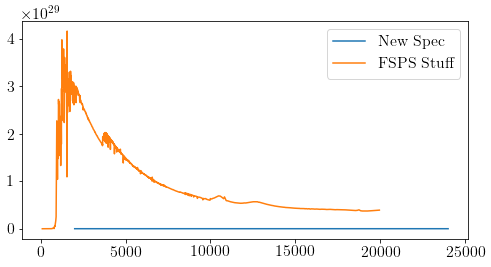

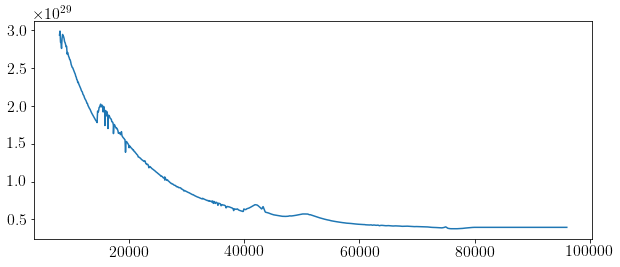

In [53]:
specFunc = interp(otherWave,useWave, cgsSpec)
print(specFunc)
print(otherSpec)

plt.figure(figsize=[8,4])
plt.plot(otherWave,otherSpec,label='New Spec')
plt.plot(useWave,cgsSpec,label='FSPS Stuff')
plt.legend(loc='best')
plt.show()

fullSpec = specFunc + otherSpec
z3_wave = otherWave*(z+1)

fig = plt.figure(figsize=(10, 4)) 
plt.plot(z3_wave,fullSpec)
